In [10]:
from IPython.utils import io
with io.capture_output() as captured:  
   %run ../../1-Preprocessing/Preprocessing/Preprocess.ipynb import x, y1, y2, X, Y1, Y2, vocabulary

#### Imports

In [11]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(device)

cpu


#### Loading the Preprocessed Data

In [13]:
train_data = TensorDataset(torch.from_numpy(x), torch.from_numpy(y1))
valid_data = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y1))

batch_size = 128

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=1024)

#### Creating the Model

In [14]:
class SequenceModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim,  hidden_dim, output_dim,  num_layers, drop_prob=0.5):
        super().__init__()

        # Network Dimensions
        self.vocab_size, self.hidden_dim, self.output_dim  = vocab_size, hidden_dim, output_dim
        self.num_layers = num_layers
    
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Drop out layer
        self.dropout = nn.Dropout(0.3)
    
        # Output Layer
        self.output = nn.Linear(self.hidden_dim, output_dim)      # Or make it linear and use Sofrmax (in loss)
   
    def forward(self, x):
        
        embeds = self.embedding(x)                                          # B * Seq_Len * embedding_dim
        
        lstm_out, _ = self.lstm(embeds)                                     # B * Seq_Len * hidden_dim
        
        lstm_out =  lstm_out[:, -1, :]                                      # B * hidden_dim

        drop_out = self.dropout(lstm_out)                                   # B * hidden_dim

        
        out = self.output(drop_out)                                         # B * output_dim
        
        return out
        

#### Initializing the Model

In [15]:
num_layers = 2
vocab_size = len(vocabulary)
embedding_dim = 128
output_dim = 3
hidden_dim = 256


model = SequenceModel(vocab_size, embedding_dim,  hidden_dim, output_dim,  num_layers).to(device)

print(model)

SequenceModel(
  (embedding): Embedding(25593, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)


#### Training & Validating the Model

In [16]:
# loss and optimization functions
lr=0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
clip = 5
epochs = 5 
epoch_tr_loss, epoch_vl_loss = [], []

for epoch in range(epochs):
    train_losses = []
    for inputs, labels in tqdm(train_loader):
        
        inputs, labels = inputs.to(device), labels.to(device)   
        
        output = model(inputs)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
    val_losses = []
    for inputs, labels in valid_loader:
        with torch.no_grad():
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            val_loss = criterion(output, labels)
            val_losses.append(val_loss.item())

        if epoch == epochs-1:
            F1 = f1_score(labels.cpu().numpy(), output.argmax(1).cpu().numpy(), average='macro')
            print(classification_report(labels.cpu().numpy(), output.argmax(1).cpu().numpy()))
            
                        
    
    epoch_tr_loss.append(np.mean(train_losses))
    epoch_vl_loss.append(np.mean(val_losses))
    print(f'Epoch {epoch+1}') 
    print(25*'==')

print("Macro F1 Score: ", F1)

100%|██████████| 55/55 [00:54<00:00,  1.00it/s]


Epoch 1


100%|██████████| 55/55 [00:55<00:00,  1.00s/it]


Epoch 2


100%|██████████| 55/55 [00:55<00:00,  1.01s/it]


Epoch 3


100%|██████████| 55/55 [00:59<00:00,  1.08s/it]


Epoch 4


100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


              precision    recall  f1-score   support

           0       0.35      0.19      0.25       126
           1       0.83      0.96      0.89       804
           2       1.00      0.01      0.03        70

    accuracy                           0.80      1000
   macro avg       0.73      0.39      0.39      1000
weighted avg       0.78      0.80      0.75      1000

Epoch 5
Macro F1 Score:  0.3882498730590742


#### Loss and Accuracy

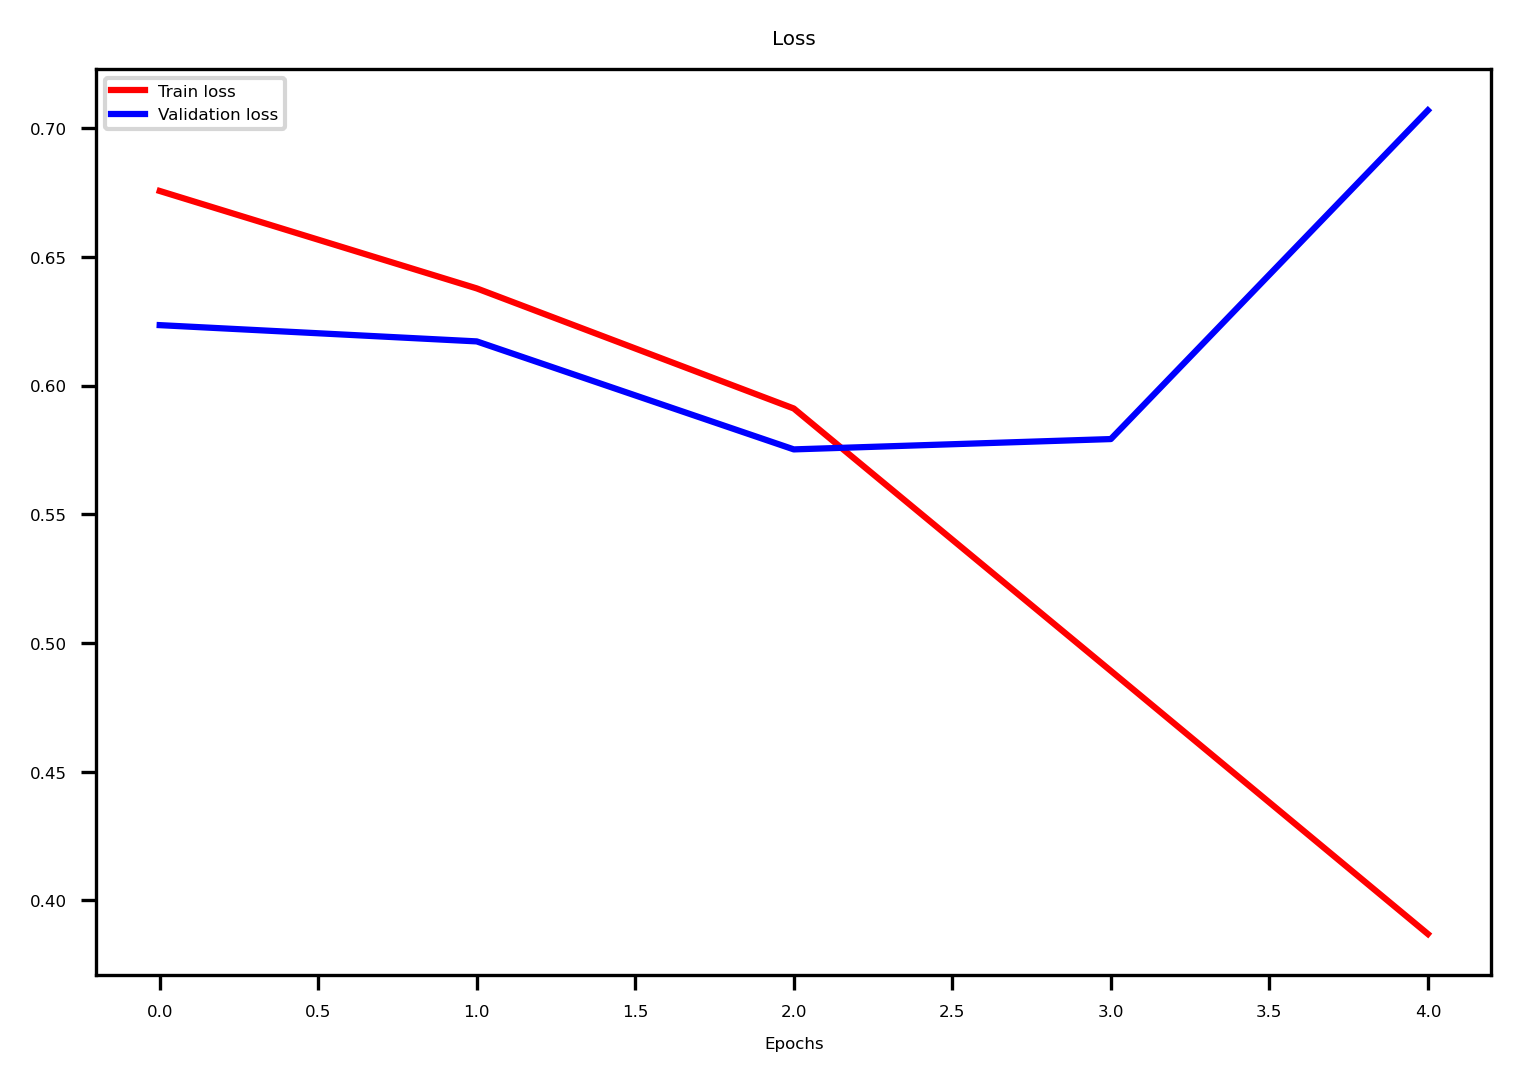

In [18]:
plt.plot(epoch_tr_loss, label='Train loss', color='red')
plt.plot(epoch_vl_loss, label='Validation loss', color='blue')
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()